## Description
This notebook examines examines how "cumulative" win-rate and average 
publisher revenue evolve over time and see how stable the mean is. 

In [1]:
## Set auto-reload
%load_ext autoreload
%autoreload 2

In [2]:
import os

from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import get_bigquery_result

%matplotlib inline

In [3]:
GCP_PROJECT = "ox-datascience-devint"
N = 10000
timeouts = [1500, 3000]

In [4]:
""" Load the data """
sql = open("sql/mean_stability_query.sql", "r").read()
filepath = "input/mean_stability_data.csv"

all_data = get_bigquery_result(sql, filepath=filepath, gcp_project=GCP_PROJECT)
display(all_data.head())

,auction_hour,bidderTimeout,win,pubrev
0,0,3000.0,0,0
1,0,3000.0,0,0
2,0,3000.0,0,0
3,0,1500.0,0,0
4,0,1000.0,0,0


In [5]:
""" Plots cumulative mean (average up to N points)"""
def plot_mean_stability(all_data, step_size, win_rate_lo=0, win_rate_hi=1, pubrev_lo=0, pubrev_hi=1e6):
    fig, ax = plt.subplots(2, 1, figsize=(7,8))
    
    for timeout in timeouts:
        df = all_data[all_data["bidderTimeout"] == timeout]
        df = df.iloc[:N * step_size]
    
        average_wins = []
        average_pubrevs = []

        num_pts = min(N, len(df) // step_size)

        for i in range(num_pts):

            sub_df = df.iloc[:i*step_size]
            average_win = sub_df["win"].mean()
            average_pubrev = sub_df["pubrev"].mean()

            average_wins.append(average_win)
            average_pubrevs.append(average_pubrev)

        idx = [i * step_size for i in range(num_pts)]

        ax[0].plot(idx, average_wins, label=f"{timeout}ms")
        ax[1].plot(idx, average_pubrevs, label=f"{timeout}ms")

    ax[0].set_title("Win rate", fontsize=15)
    ax[1].set_title("Average pubrev", fontsize=15)

    ax[0].set_xlabel("Num data pts", fontsize=13)
    ax[1].set_xlabel("Num data pts", fontsize=13)
    ax[0].set_ylabel("Win rate", fontsize=13)
    ax[1].set_ylabel("Pubrev (1e-9 usd)", fontsize=13)
    ax[0].set_ylim(win_rate_lo, win_rate_hi)
    ax[1].set_ylim(pubrev_lo, pubrev_hi)
    
    ax[0].legend()
    ax[1].legend()
    
    fig.suptitle(f"step size={step_size}", fontsize=15)
    fig.tight_layout()
    
    if not os.path.exists("output/"):
        os.mkdir("output")    
    fig.savefig(f"output/mean_stability_step_size={step_size}.png", dpi=150, transparent=False)

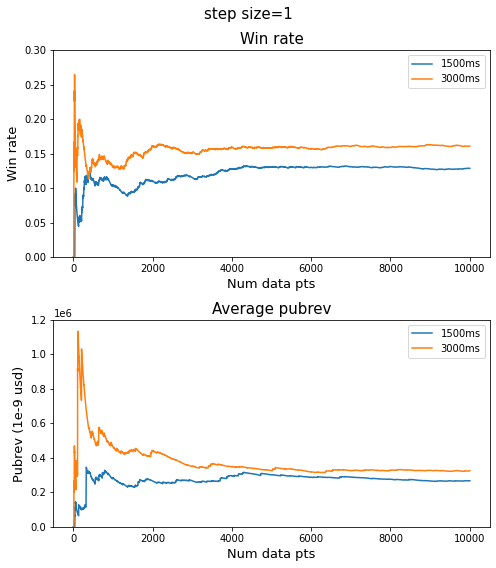

In [6]:
plot_mean_stability(all_data, step_size=1, win_rate_hi=0.3, pubrev_hi=1.2e6)

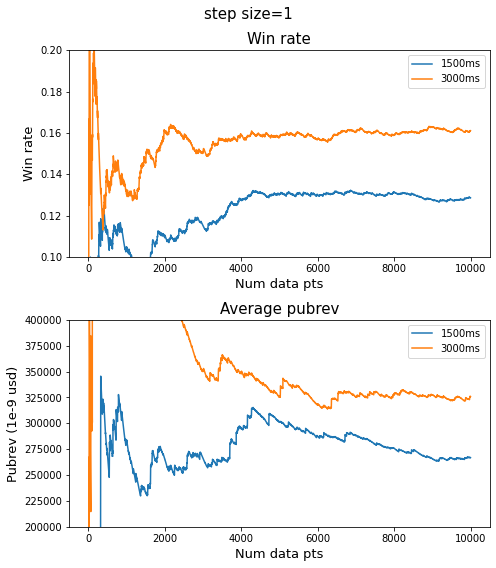

In [7]:
plot_mean_stability(all_data, step_size=1, win_rate_lo=0.1, win_rate_hi=0.2, pubrev_lo=2e5, pubrev_hi=4e5)

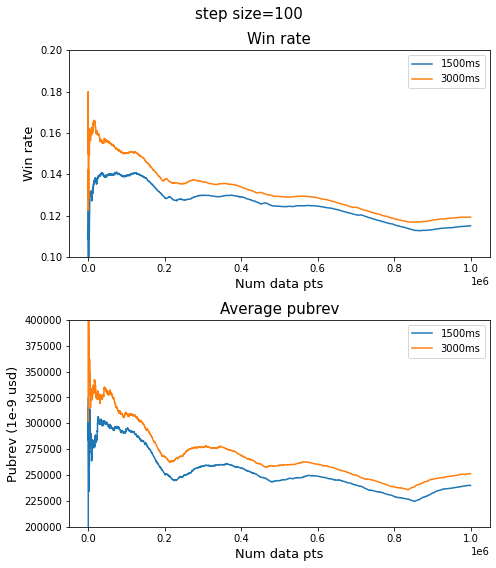

In [8]:
plot_mean_stability(all_data, step_size=100, win_rate_lo=0.1, win_rate_hi=0.2, pubrev_lo=2e5, pubrev_hi=4e5)

In [9]:
""" Plots cumulative mean (average up to N hours) and lift in win-rate and average pubrev """
def plot_mean_stability_hourly(
        all_data, win_rate_lo=0, win_rate_hi=1, pubrev_lo=0, pubrev_hi=1e6,
        wr_lift_lo=0, wr_lift_hi=0.25, rev_lift_lo=0, rev_lift_hi=0.2
):
    fig, ax = plt.subplots(2, 2, figsize=(14,8))
    
    results = {}
    for timeout in timeouts:
        df = all_data[all_data["bidderTimeout"] == timeout]
    
        results[timeout] = {}
        average_wins = []
        average_pubrevs = []

        num_hours = df["auction_hour"].nunique()

        for hr in range(num_hours):
            sub_df = df[df["auction_hour"] < hr+1]
            average_win = sub_df["win"].mean()
            average_pubrev = sub_df["pubrev"].mean()

            average_wins.append(average_win)
            average_pubrevs.append(average_pubrev)

        ax[0,0].plot(average_wins, label=f"{timeout}ms")
        ax[1,0].plot(average_pubrevs, label=f"{timeout}ms")

        results[timeout]["average_wins"] = np.array(average_wins)
        results[timeout]["average_pubrevs"] = np.array(average_pubrevs)        

    ax[0,1].plot(results[3000]["average_wins"] / results[1500]["average_wins"] - 1)
    ax[1,1].plot(results[3000]["average_pubrevs"] / results[1500]["average_pubrevs"] - 1)

    ax[0,0].set_title("Average win rate", fontsize=14)
    ax[1,0].set_title("Average pubrev", fontsize=14)
    ax[0,1].set_title("Average win rate lift", fontsize=14)
    ax[1,1].set_title("Average pubrev lift", fontsize=14)

    ax[0,0].set_xlabel("hours", fontsize=13)
    ax[1,0].set_xlabel("hours", fontsize=13)
    ax[0,1].set_xlabel("hours", fontsize=13)
    ax[1,1].set_xlabel("hours", fontsize=13)
    ax[0,0].set_ylabel("win rate", fontsize=13)
    ax[1,0].set_ylabel("Pubrev (1e-9 usd)", fontsize=13)
    ax[0,1].set_ylabel("win rate lift", fontsize=13)
    ax[1,1].set_ylabel("Pubrev lift", fontsize=13)
    
    ax[0,0].set_ylim(win_rate_lo, win_rate_hi)
    ax[1,0].set_ylim(pubrev_lo, pubrev_hi)
    ax[0,1].set_ylim(wr_lift_lo, wr_lift_hi)
    ax[1,1].set_ylim(rev_lift_lo, rev_lift_hi)
    
    ax[0,0].legend()
    ax[1,0].legend()
    
    fig.suptitle(f"step size=1hr", fontsize=15)
    fig.tight_layout()
    
    if not os.path.exists("output/"):
        os.mkdir("output")    
    fig.savefig(f"output/mean_stability_step_size=1hr.png", dpi=150)

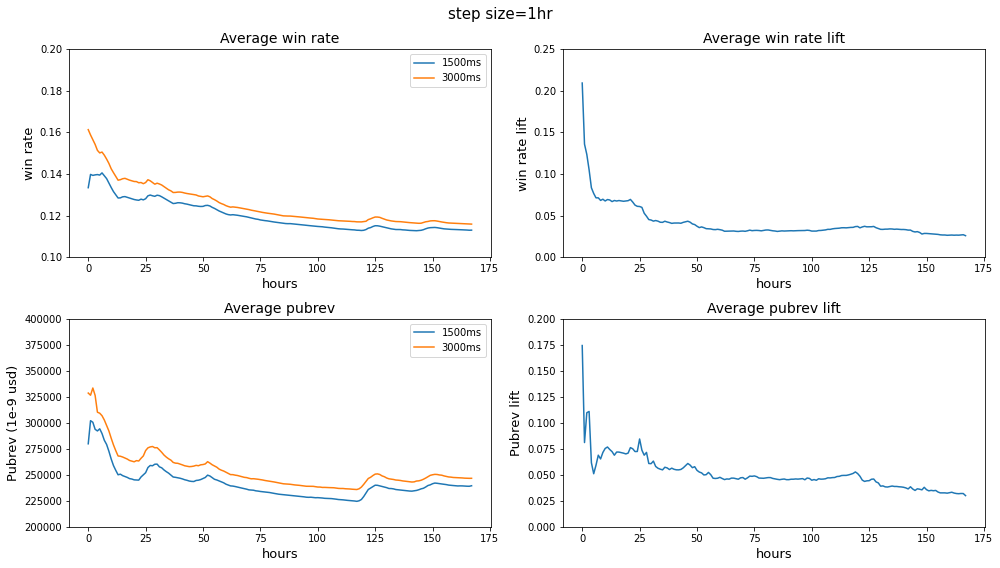

In [10]:
plot_mean_stability_hourly(
    all_data, win_rate_lo=0.1, win_rate_hi=0.2, pubrev_lo=2e5, pubrev_hi=4e5, 
    wr_lift_lo=0, wr_lift_hi=0.25, rev_lift_lo=0, rev_lift_hi=0.2
)